# Multiclass segmentation: PyTorch version
We want to optimize the mean Jaccard index of the non-void classes.

In [1]:
!wget https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/pytorch/lovasz_losses.py
!wget https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/demo_helpers/demo_utils.py

--2024-03-01 04:06:03--  https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/pytorch/lovasz_losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8352 (8.2K) [text/plain]
Saving to: ‘lovasz_losses.py’

lovasz_losses.py    100%[===================>]   8.16K  --.-KB/s    in 0s      

2024-03-01 04:06:03 (74.5 MB/s) - ‘lovasz_losses.py’ saved [8352/8352]

--2024-03-01 04:06:03--  https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/demo_helpers/demo_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import division, print_function

In [4]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn

In [5]:
import lovasz_losses as L

/content/lovasz_losses.py:186: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (classes is 'present' and fg.sum() == 0):


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from tqdm import tqdm_notebook as tqdm

In [8]:
# add parent path to pythonpath to import demo_utils
import sys
sys.path.append('../demo_helpers')
from demo_utils import pil, pil_grid, dummy_triangles

In [9]:
from collections import OrderedDict as OD

In [10]:
CUDA = True

In [11]:
def cuda(x):
    if CUDA:
        return x.cuda()
    else:
        return x

## Multiclass case: batch of 5 random images with classes [0, 1, 2] and void (255)
We assume that we want to optimize the Jaccard index of all non-void classes 0, 1 and 2.

### Labels

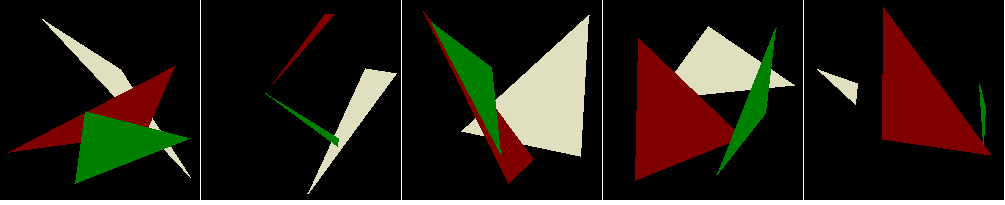

In [12]:
np.random.seed(18)
C = 3
B = 5
H = 200
labels_ = [dummy_triangles(H, [0, 255, 1, 2]) for b in range(B)]
labels = torch.stack([torch.from_numpy(a) for a in map(np.array, labels_)]).long()
pil_grid(labels_, 5, margin=1)

### Features

In [13]:
np.random.seed(57)
B, H, W = labels.size()
labels_ = labels.clone()
labels_[labels_ == 255] = labels_[labels_ == 255].random_(C) # random feats for void
labels_1hot = torch.zeros(B, C, H, W)
labels_1hot.scatter_(1, labels_.unsqueeze(1), 1);

In [14]:
feats = labels_1hot.clone().float()
feats += feats.new(feats.size()).normal_(0, 2) # additive gaussian noise

In [15]:
# labels = cuda(labels)
# feats = Variable(cuda(feats))

## Model

### definition

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, padding=1)

    def forward(self, x):
        return x + self.conv(x)

In [17]:
m = Model()
init_state_dict = OD([(n, p.clone()) for (n, p) in m.state_dict().items()])

In [18]:
# m = cuda(m)

### Initial prediction

In [19]:
_, preds = m(feats).data.max(1)
print("Initial batch-IoUs:", L.iou(preds, labels, C, ignore=255, per_image=False))
print("Initial mIoU:", np.mean(L.iou(preds, labels, C, ignore=255, per_image=False)))

Initial batch-IoUs: [49.17389863 17.03550942  7.35925884]
Initial mIoU: 24.52288896563637


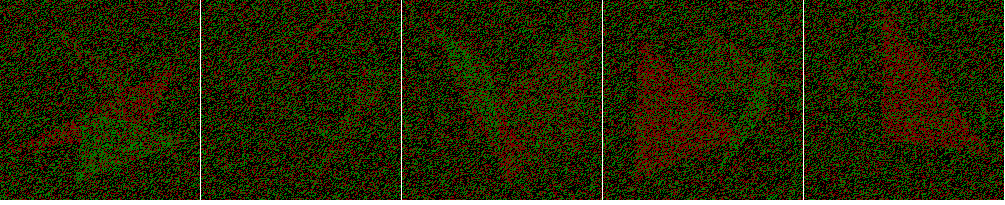

In [20]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Lovász-Softmax training

In [21]:
m.load_state_dict(init_state_dict)

optimizer = Adam(m.parameters(), lr=0.005)

loss_plot = []
iou_plot = []

for iter in tqdm(range(1000)):
    optimizer.zero_grad()
    out = m(feats)
    out = F.softmax(out, dim=1)
    print(f"shape of out: {out.shape}, shape of labels:{labels.shape}")
    loss = L.lovasz_softmax(out, labels, ignore=255)
    loss.backward()
    optimizer.step()

    _, preds = out.data.max(1)
    loss_plot.append(loss.item())
    print(f"shape of out after pass it to loss: {out.shape}")
    print(f"shape of preds: {preds.shape}")
    iou_plot.append(L.iou_binary(preds, labels, ignore=255, per_image=False))

<ipython-input-21-64fc4e305a99>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iter in tqdm(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

shape of out: torch.Size([5, 3, 200, 200]), shape of labels:torch.Size([5, 200, 200])
shape of out after pass it to loss: torch.Size([5, 3, 200, 200])
shape of preds: torch.Size([5, 200, 200])
shape of out: torch.Size([5, 3, 200, 200]), shape of labels:torch.Size([5, 200, 200])
shape of out after pass it to loss: torch.Size([5, 3, 200, 200])
shape of preds: torch.Size([5, 200, 200])
shape of out: torch.Size([5, 3, 200, 200]), shape of labels:torch.Size([5, 200, 200])
shape of out after pass it to loss: torch.Size([5, 3, 200, 200])
shape of preds: torch.Size([5, 200, 200])
shape of out: torch.Size([5, 3, 200, 200]), shape of labels:torch.Size([5, 200, 200])
shape of out after pass it to loss: torch.Size([5, 3, 200, 200])
shape of preds: torch.Size([5, 200, 200])
shape of out: torch.Size([5, 3, 200, 200]), shape of labels:torch.Size([5, 200, 200])
shape of out after pass it to loss: torch.Size([5, 3, 200, 200])
shape of preds: torch.Size([5, 200, 200])
shape of out: torch.Size([5, 3, 200

Text(0.5, 0, 'iteration')

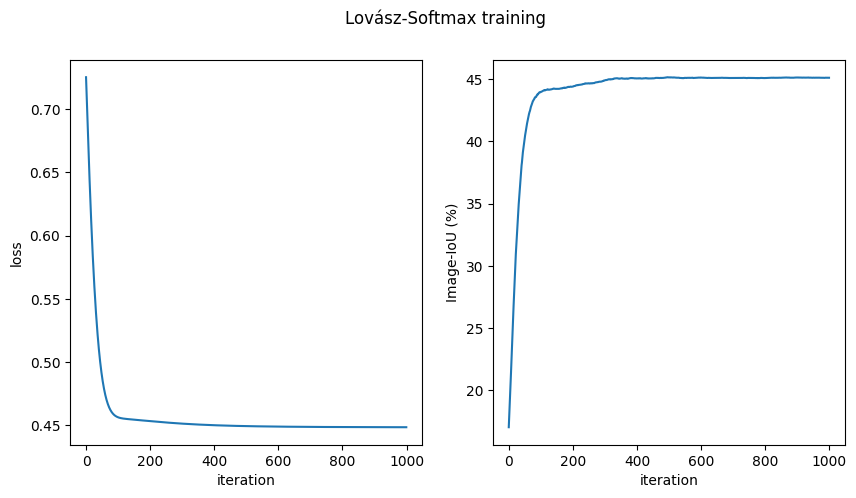

In [22]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Lovász-Softmax training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

### Final prediction

In [23]:
_, preds = m(feats).data.max(1)
print("Final batch-IoUs:", L.iou(preds, labels, C, ignore=255, per_image=False))
print("Final mIoU:", np.mean(L.iou(preds, labels, C, ignore=255, per_image=False)))

Final batch-IoUs: [87.46542886 45.1200058  31.11143001]
Final mIoU: 54.565621556996085


In [24]:
a = m(feats)
print(f"shape of pred using lovasz softmax: {a.shape}")

shape of pred using lovasz softmax: torch.Size([5, 3, 200, 200])


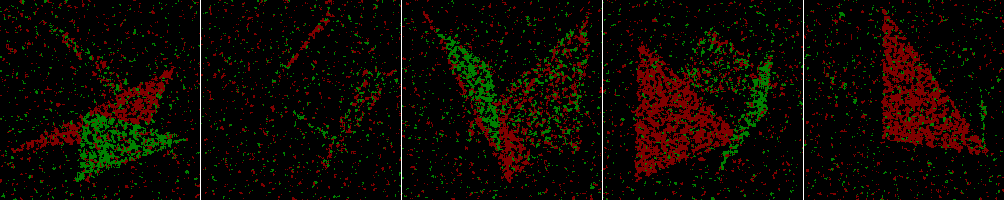

In [25]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Cross-entropy training

In [26]:
m.load_state_dict(init_state_dict)

optimizer = Adam(m.parameters(), lr=0.005)

loss_plot_x = []
iou_plot_x = []

for iter in tqdm(range(1000)):
    optimizer.zero_grad()
    out = m(feats)
    loss = L.xloss(out, labels, ignore=255)
    loss.backward()
    optimizer.step()

    _, preds = out.data.max(1)
    loss_plot_x.append(loss.item())
    iou_plot_x.append(L.iou_binary(preds, labels, ignore=255, per_image=False))

<ipython-input-26-85e610be09aa>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iter in tqdm(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 0, 'iteration')

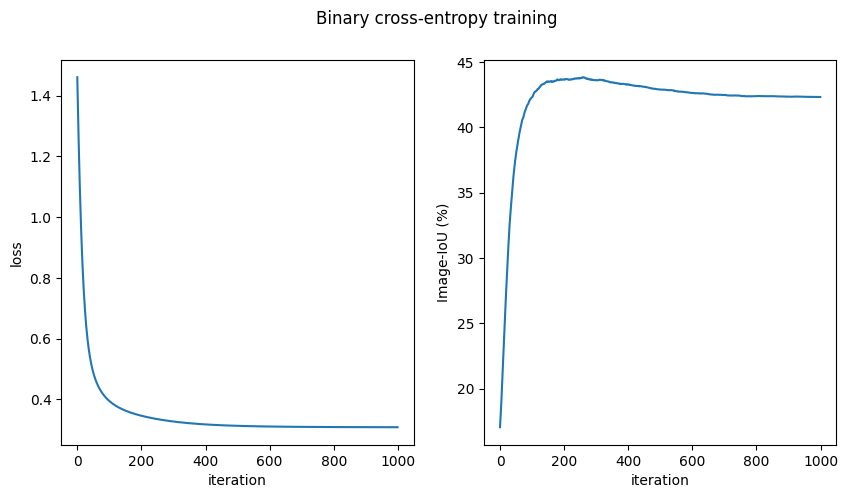

In [27]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Binary cross-entropy training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot_x)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot_x)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

### Final prediction

In [28]:
_, preds = m(feats).data.max(1)
print("Final batch-IoUs:", L.iou(preds, labels, C, ignore=255, per_image=False))
print("Final mIoU:", np.mean(L.iou(preds, labels, C, ignore=255, per_image=False)))

Final batch-IoUs: [88.54253827 42.33371373 26.08862092]
Final mIoU: 52.321624306500546


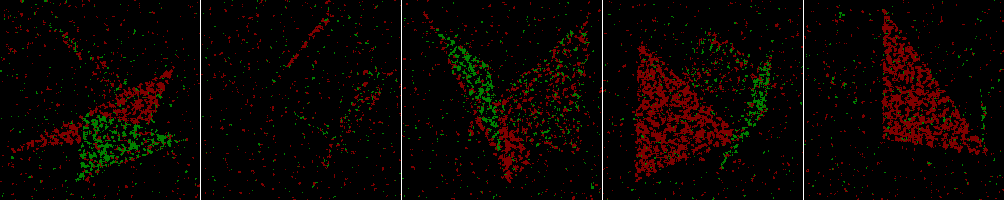

In [29]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

In [30]:
shape_pred = m(feats)
